In [1]:
def set_jupyter_widescreen():
    from IPython.display import display, HTML
    
    display(HTML(data="""
    <style>
        div#notebook-container    {width: 95%; }
        div#menubar-container     {width: 65%; }
        div#maintoolbar-container {width: 99%; }
    </style>
    """))
set_jupyter_widescreen()

In [2]:
import os
import re
import time
import json
import openai
import numpy as np
import traceback
import matplotlib.pyplot as plt
from dotenv import load_dotenv, find_dotenv

import langchain.chat_models
import langchain.schema
from langchain.callbacks import get_openai_callback
from langchain import OpenAI
from langchain.schema import (HumanMessage, AIMessage)

import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None

_ = load_dotenv(find_dotenv())

open_api_key = os.environ["OPENAI_API_KEY"]

In [3]:
class LLM_PlotGenerator:
    """Plot data using matplotlib

    Args:
        prompt (str): prompt that explains the desired plot.
            Example: "plot the data as a line graph"
        data (object): Data to be plotted. Can be any object
            that matplotlib can plot. Example: a list of numbers,
            a numpy array, a pandas dataframe, etc.
        max_attempts (int): set a limit to the number of attempts if encountered error
        openai_api_key (str, optional): OpenAI API key. Defaults to None.
        fig_args (dict, optional): Arguments to pass to `plt.figure`.
    """
    def __init__(self, max_attempts: int = 3, openai_api_key: str = None, model: str = 'gpt-3.5-turbo', fig_args: dict = {}, verbose: bool = False):

        self.open_api_key = open_api_key or os.getenv('OPENAI_API_KEY')
        if not self.open_api_key:
            raise ValueError("An OpenAI API key is required.")
            
        self.max_attempts = max_attempts
        self.model = model
        self.verbose = verbose
        
        self.prompt_history = ""
        self.llm_response_history = []

        
    
    def plot(self, prompt: str, data: object, fig_args: dict = {}) -> None:
        data_description = self.describe_data(data)
        # save full_prompt internally for revisions
        full_prompt = self.create_full_prompt(prompt, data_description)        
        code, llm_response = self.get_code_from_llm(full_prompt)
        self.execute_plot(code, data, fig_args)
    
    
    def generate_df_description(self, df: pd.DataFrame)-> str:
        description = f"The dataframe has {df.shape[0]} rows and {df.shape[1]} columns."
        description += f"The columns are named {list(df.columns)}."
        description += f"The first 5 rows are: \n{df.head(5)}"
        return description

    
    def describe_data(self, data: object) -> str:
        if isinstance(data, pd.DataFrame): 
            return self.generate_df_description(data)
        elif isinstance(data, np.ndarray):
            return f"The data variable is of type {type(data)} and has dimensions {data.shape}. The first rows are: \n{data[:5]}"
        else:
            return f"The data variable is of type {type(data)}."
    
    
    def create_full_prompt(self, prompt: str, data_description: str) -> str:
        return f"You are a Python programmer. Your job is to write Python code. Given a data set named `data`, please write Python code below to create a plot with matplotlib that satifies the following description: '{prompt}'. \n\n Note: you can assume that `data` is an existing variable that can be used. {data_description}. Remember to assume that `data` is an existing variable that can be used, do reset the `data` variable. \n\n Python code (as markdown Python code block):"
        
    
    def get_code_from_llm(self, full_prompt: str) -> (str,str):
        llm = langchain.chat_models.ChatOpenAI(
            model_name=self.model,
            openai_api_key=self.open_api_key,
        )
        if self.verbose:
            print(f"prompting LLM with the following: \n{full_prompt}")
            print(f"{''.join(100*['*'])}")
        
        # get plotting code from LLM
        print("Prompting LLM for code... (this may take a few seconds)")
        
        with get_openai_callback() as cb:
            llm_response = llm(messages=[HumanMessage(content=full_prompt)]).content
            if self.verbose:
                print(f"token cost: \n{cb}")
                print(f"{''.join(100*['*'])}")
        
        # save llm response history
        self.llm_response_history.append(llm_response)
        
        try:
            code = llm_response.split("```python")[1].split("```")[0]
        except IndexError:
            raise ValueError(
                "The LLM did not return any code. "
                "Please try again (maybe with a different prompt)."
                f"LLM response: {llm_response}")
        
        # concatenate the initial code to initial full prompt
        self.prompt_history = full_prompt + '\n' + code
#         print('Showing the prompt history...')
#         print('\n\n')
#         print(self.prompt_history)
#         print('\n\n')
        
        if self.verbose:
            print(f"Code generated by LLM: {code}")  
            print(f"{''.join(100*['*'])}")
        
        return code, llm_response
    
    
    def revised_code_from_llm(self, revised_message: str) -> (str,str):
        # Reformulate prompt with error message
        self.prompt_history += f"\n\nError encountered: {revised_message}. Please revise the code to fix this issue. \n\n Ensure tha the Python code is generated as markdown Python code block:"
        code, llm_response = self.get_code_from_llm(full_prompt=self.prompt_history)
        return code, llm_response
      
        
    def execute_plot(self, code: str, data: object, fig_args: dict = {}) -> None:
        for attempt in range(self.max_attempts):
            try:
                fig = plt.figure(**fig_args)
                exec(code, {"data": data, "fig":fig})
                if self.verbose:
                    print(f"Plot generated successfully on attempt {attempt + 1}")
                return
#                 try:
#                     feedback= "Please enter any additional adjustmets? if none press n"
#                     user_comment = input(feedback)
#                     if user_comment != "n" and attempt < self.max_attempts - 1:
#                         code, _ = self.revised_code_from_llm(revised_message=user_comment, message_type='adjustment')                    
#                     else:
#                         return
#                 except Exception as e:
#                     print(e)
#                     return
            except Exception as e:
                fig.clf() 
                if attempt < self.max_attempts - 1:
                    error_message = traceback.format_exc()
                    print(f"An error occurred: {error_message}. \nAttempting again...")
                    code, _ = self.revised_code_from_llm(revised_message=error_message)
                else:
                    raise


In [4]:
prompt_dict = {
    'time_series_plot':"Create a time series plot to analyze the transaction trends over the two-month period. Plot the sum of 'Transaction_Amount' per day on the y-axis, with the 'Date' column on the x-axis. Aggregate the data by each day and display the daily total transaction amount. If the dataset spans only one year, format the x-axis to show month and day. Ensure the date labels are clear and non-overlapping, possibly by angling or spacing them appropriately. Add a title, and axis labels to provide context. Use a color and line style that is professional and easy to read. Highlight any outlier transactions where the daily total exceeds a significant threshold, such as 200,000, with a distinct marker or color."
    , 'pie_chart': "Generate a pie chart to represent the distribution of different transaction types. Each slice of the pie should correspond to a unique 'Transaction_Type', with the size of each slice reflecting the count of transactions of that type. Include a legend to identify the transaction types, and ensure the chart is color-coded for clear differentiation. Add percentage labels to each slice for a more informative presentation."
    , 'bar_chart': "Plot a bar chart to compare the total transaction amounts for each 'Transaction_Purpose'. Arrange the 'Transaction_Purpose' categories along the x-axis, and plot the sum of 'Transaction_Amount' for each category on the y-axis. Use different colors for each bar for easy comparison, and add value labels on top of each bar to display the exact total amounts. Ensure the chart is titled appropriately and includes axis labels for clarity."
    , 'histogram': "Create a histogram to visualize the distribution of transaction amounts. Use appropriate bin sizes to display the range and frequency of 'Transaction_Amount' values. Ensure the histogram has clear labels for both axes, a title, and uses a color scheme suitable for a professional setting. Optionally, include a line representing the mean transaction amount for reference."
    , 'boxplot': "Construct a boxplot to analyze the distribution of transaction amounts across different transaction types. Each box should represent a different 'Transaction_Type', with the 'Transaction_Amount' on the y-axis. Include median values and outliers in the plot. Use a color scheme to differentiate between transaction types, and label each box clearly. Add a chart title and axis labels for a complete and professional presentation."
    , 'stacked_bar_chart': "Develop a stacked bar chart to show the evolution of transaction amounts over time, broken down by transaction type. Use 'Date' for the x-axis, and stack segments representing different 'Transaction_Type' categories on the y-axis, each showing the sum of 'Transaction_Amount' for that day and type. Choose a distinct color for each transaction type, and add a legend for identification. Ensure the chart has clear labels and a title for executive understanding."
    , 'heatmap': "Plot a heatmap to display the concentration of transactions by day and type. Organize the days on one axis and 'Transaction_Type' on the other, with the intensity of color indicating the total 'Transaction_Amount' for each combination. Use a color gradient that is easily interpretable and visually appealing in a professional context. Include a color bar for reference, and label the axes and the chart effectively."
}

In [5]:
print(prompt_dict['pie_chart'])

Generate a pie chart to represent the distribution of different transaction types. Each slice of the pie should correspond to a unique 'Transaction_Type', with the size of each slice reflecting the count of transactions of that type. Include a legend to identify the transaction types, and ensure the chart is color-coded for clear differentiation. Add percentage labels to each slice for a more informative presentation.


Prompting LLM for code... (this may take a few seconds)


<Figure size 500x500 with 0 Axes>

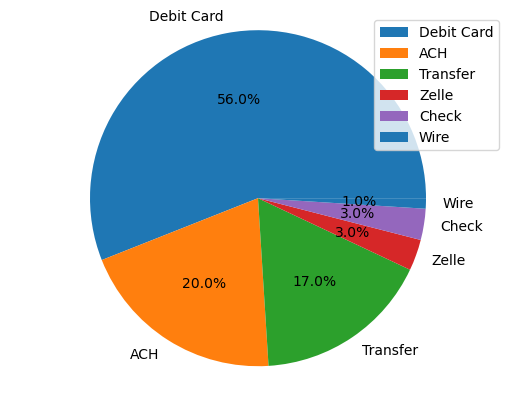

In [7]:
df = pd.read_excel("./data/ROBERT_KING.xlsx", index_col =0)
prompt = prompt_dict['pie_chart']
fig_args = {'figsize': (5,5)}
plot_generator = LLM_PlotGenerator(fig_args=fig_args, verbose=False, max_attempts=10)
plot_generator.plot(prompt, df, fig_args)

In [11]:
print(prompt_dict['histogram'])

Create a histogram to visualize the distribution of transaction amounts. Use appropriate bin sizes to display the range and frequency of 'Transaction_Amount' values. Ensure the histogram has clear labels for both axes, a title, and uses a color scheme suitable for a professional setting. Optionally, include a line representing the mean transaction amount for reference.


Prompting LLM for code... (this may take a few seconds)


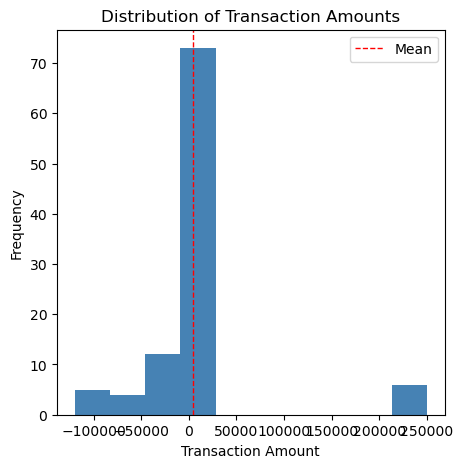

In [12]:
df = pd.read_excel("./data/ROBERT_KING.xlsx", index_col =0)
prompt = prompt_dict['histogram']
fig_args = {'figsize': (5,5)}
plot_generator = LLM_PlotGenerator(fig_args=fig_args, verbose=False, max_attempts=10)
plot_generator.plot(prompt, df, fig_args)

In [9]:
print(prompt_dict['bar_chart'])

Plot a bar chart to compare the total transaction amounts for each 'Transaction_Purpose'. Arrange the 'Transaction_Purpose' categories along the x-axis, and plot the sum of 'Transaction_Amount' for each category on the y-axis. Use different colors for each bar for easy comparison, and add value labels on top of each bar to display the exact total amounts. Ensure the chart is titled appropriately and includes axis labels for clarity.


Prompting LLM for code... (this may take a few seconds)


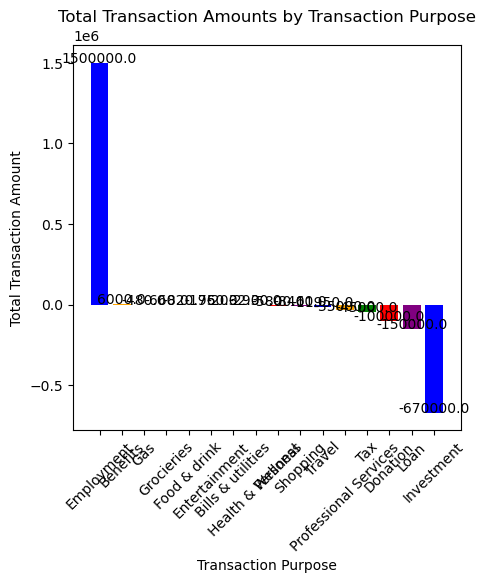

In [10]:
df = pd.read_excel("./data/ROBERT_KING.xlsx", index_col =0)
prompt = prompt_dict['bar_chart']
fig_args = {'figsize': (5,5)}
plot_generator = LLM_PlotGenerator(fig_args=fig_args, verbose=False, max_attempts=10)
plot_generator.plot(prompt, df, fig_args)

In [ ]:
print(prompt_dict['time_series_plot'])

In [ ]:
# load the dataframe and add description
prompt = prompt_dict['time_series_plot']
df = pd.read_excel("./data/ROBERT_KING.xlsx", index_col =0)

In [ ]:
fig_args = {'figsize': (5,5)}
plot_generator = LLM_PlotGenerator(fig_args=fig_args, verbose=False, max_attempts=10)
plot_generator.plot(prompt, df, fig_args)

In [ ]:
llm_prompt_dict = {'time_series_plot': {'llm_response_hist': plot_generator.llm_response_history, 'prompt_hist': plot_generator.prompt_history}}